In [1]:
import numpy as np
import pandas as pd

# Машинное обучение

In [2]:
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv('archive_churn_modelling/Churn_Modelling.csv')

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


# Разбивка на выборки train, val, test

In [5]:
from sklearn.model_selection import train_test_split

# чтобы избегать неравносмерности доли целевого параметра нужно задавать startify

train, test = train_test_split(df, train_size = 0.6, random_state = 42, stratify = df['Exited'])

In [6]:
val, test = train_test_split(test, train_size = 0.5, random_state = 42, stratify = test['Exited'])

In [7]:
# делаем проверку:

print(train['Exited'].mean())
print(val['Exited'].mean())
print(test['Exited'].mean())

0.20366666666666666
0.204
0.2035


# Задаем фичи

In [41]:
# список всех фичей:

test.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'SCORE_prod_age_active'],
      dtype='object')

In [9]:
# обучимся на тех фичах, на которых делали человеческое обучение:

X = ['NumOfProducts', 'Age', 'IsActiveMember']
y = ['Exited']

# не задаем список категориальных фичей, потому что все выбранные фичи - числовые.

In [18]:
# создаем параметры: 'learning_rate': сначала не задавали, потом 0.03, потом - 0.01 (добиваемся конечной итерации ближе к 998)

params = {'verbose':100,
         'random_seed': 42,
         'learning_rate': 0.01}

In [19]:
# создаем модель с этими параметрами:

model_1 = CatBoostClassifier(**params)

In [20]:
# запускаем обучение:

model_1.fit(train[X], train[y], eval_set = (val[X], val[y]))

0:	learn: 0.6849803	test: 0.6849389	best: 0.6849389 (0)	total: 2.66ms	remaining: 2.66s
100:	learn: 0.3991169	test: 0.3930537	best: 0.3930537 (100)	total: 219ms	remaining: 1.95s
200:	learn: 0.3659581	test: 0.3563817	best: 0.3563817 (200)	total: 417ms	remaining: 1.66s
300:	learn: 0.3589224	test: 0.3476566	best: 0.3476566 (300)	total: 613ms	remaining: 1.42s
400:	learn: 0.3565171	test: 0.3446648	best: 0.3446648 (400)	total: 810ms	remaining: 1.21s
500:	learn: 0.3553274	test: 0.3433005	best: 0.3432984 (498)	total: 1.01s	remaining: 1.01s
600:	learn: 0.3544987	test: 0.3425379	best: 0.3425379 (600)	total: 1.23s	remaining: 813ms
700:	learn: 0.3539638	test: 0.3421168	best: 0.3421135 (699)	total: 1.42s	remaining: 604ms
800:	learn: 0.3532817	test: 0.3419139	best: 0.3419139 (800)	total: 1.6s	remaining: 399ms
900:	learn: 0.3524351	test: 0.3416923	best: 0.3416923 (900)	total: 1.79s	remaining: 197ms
999:	learn: 0.3513546	test: 0.3417688	best: 0.3416551 (927)	total: 2s	remaining: 0us

bestTest = 0.34165

In [21]:
# проверка модели на тесте:

# при помощи model.predict_proba() - получаем две колонки SCORE - скор на то что чел останется, скор на то что чел уйдет:
# в сумме эти скоры для каждого человека равны 1

model_1.predict_proba(test[X])

array([[0.87273278, 0.12726722],
       [0.83992875, 0.16007125],
       [0.76421314, 0.23578686],
       ...,
       [0.85243229, 0.14756771],
       [0.96002386, 0.03997614],
       [0.95396298, 0.04603702]])

In [23]:
# в данном случае нам нужен скор только на отток (Exited):

model_1.predict_proba(test[X])[:, 1]

array([0.12726722, 0.16007125, 0.23578686, ..., 0.14756771, 0.03997614,
       0.04603702])

In [25]:
# добавим колонку со SCORE на отток в тестовую выборку:

test['SCORE_prod_age_active'] = model_1.predict_proba(test[X])[:, 1]

In [45]:
# еще добавим BaseLine - среднее значение по тестовой выборке:
test['Baseline'] = test['Exited'].mean()

In [40]:
# Полученный столбец test['SCORE_prod_age_active'] - не уникальный:
# есть много повторяющихся комбинаций и CatBoost задает им одинаковый SCORE:
# (от полностью идентичных скоров можно избавиться добавив мелкий уникальный шум к каждому значению)


# Всего наблюдений в тесте
print('Всего наблюдений в тесте: ', len(test['SCORE_prod_age_active']))

# уникальных наблюдений SCORE в тесте
print('Уникальных наблюдений SCORE в тесте: ', len(test['SCORE_prod_age_active'].unique()))

Всего наблюдений в тесте:  2000
Уникальных наблюдений SCORE в тесте:  254


### Считаем метрики log_loss и uplift

#### Метрика log_loss

In [46]:
from sklearn.metrics import log_loss

# рассчитываем показатель log_loss на тесте для mean (среднего значения по этой выборке - Baseline):
print(log_loss(test['Exited'], test['Baseline']))


# рассчитываем показатель log_loss для сделанного скора:
print(log_loss(test['Exited'], test['SCORE_prod_age_active']))

0.5052163384611609
0.35878132799643003


#### Метрика uplift

In [ ]:
# Метрика uplift поднимает большие значения прогноза вверх, после чего их можно снимать как сливки 
# и по этим сливкам смотеть самые интересные данные о целевом признаке. 
# И проверять как наш алгоритм поднимает эти сливки наверх - хорошо или не очень.
# в данном случае о количестве ушедших.
# сначала снимается например 20% случайной выборки (sample), а затем производится сортировка по нашему прогнозному признаку
# (в данном случае это score_prod) и берется 20% сливок сверху. Потом делится первое на второе
# В результате получаем отношение данных о целевом признаке по "сливкам" (uplift - данным) к рандомному выбору.
# Таким образом получаем во сколько раз наш прогноз лучше рандомного прогноза.
# во сколько раз обгоняется по точности рандомная модель

In [48]:
# создаем функцию для расчета uplift:

# функция принмает df, определенный столбец со SCORE и pct - это сколько процентов выборки мы берем:
def uplift(df, score, pct):
    # посчитаем сколько всего в выборке отточных клиентов:
    exited_all = df['Exited'].sum()
    
    # отсортируем df по SCORE:
    df_sorted = df.sort_values(by = score, ascending = False)
    
    
    # теперь надо взять топ-20% этой отсортированной выборки:

    # получаем количество записей которые будут соответствовать pct % всей выборки:
    sorted_20 = round(len(df) * pct)
    
    # посчитаем сколько отточников нашлось в этих сортированных по score_prod строках:
    exited_found = df_sorted.head(sorted_20)['Exited'].sum()
    
    return (exited_found / exited_all) / pct    

In [50]:
# расчитаем метрику uplift для тестовой выборки, Baseline и 20%:

uplift(test, 'Baseline', 0.2)

1.0442260442260443

In [49]:
# расчитаем метрику uplift для тестовой выборки, SCORE_prod_age_active и 20%:
# во сколько раз обгоняется по точности рандомная модель:

uplift(test, 'SCORE_prod_age_active', 0.2)

2.899262899262899

# Machine learning на всех фичах

In [56]:
train

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0
5705,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0
9058,9059,15802560,Moran,470,Spain,Female,48,6,140576.11,1,1,1,116971.05,0
9415,9416,15750407,Hunt,768,Germany,Female,43,2,129264.05,2,0,0,19150.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1468,15681843,Barbour,624,Germany,Female,35,0,180303.24,2,1,0,163587.90,0
4644,4645,15714240,Ponomarev,712,Spain,Male,74,5,0.00,2,0,0,151425.82,0
8942,8943,15709780,Azuka,667,France,Female,37,9,71786.90,2,1,1,67734.79,0
2935,2936,15689425,Olejuru,687,Spain,Male,35,8,100988.39,2,1,0,22247.27,0


In [57]:
train.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [98]:
# обучимся на тех фичах, на которых делали человеческое обучение:

X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
y = ['Exited']

# категориальные фичи = ['Geography', 'Gender']
cat_features = ['Geography', 'Gender']


In [99]:
# взяли кусок кода с pool c Tutorial: CatBoost Overview (https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview)

from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [100]:
# на тестовой выборке 'learning_rate': не задаем потому что не знаем какой он будет

params_2 = {'verbose':100,
         'random_seed': 42}

In [101]:
model_2 = CatBoostClassifier(**params_2)

In [102]:
# запускаем обучение:

# так мы запускали раньше:
# model_2.fit(train[X], train[y], eval_set = (val[X], val[y]))

# с использованием Pool для более чистого кода:
model_2.fit(train_data, eval_set = valid_data)

Learning rate set to 0.04933
0:	learn: 0.6535333	test: 0.6537816	best: 0.6537816 (0)	total: 57.2ms	remaining: 57.2s
100:	learn: 0.3121251	test: 0.3227529	best: 0.3227529 (100)	total: 4.18s	remaining: 37.2s
200:	learn: 0.2825968	test: 0.3200314	best: 0.3191361 (160)	total: 9.26s	remaining: 36.8s
300:	learn: 0.2540340	test: 0.3217938	best: 0.3191361 (160)	total: 13.7s	remaining: 31.8s
400:	learn: 0.2320413	test: 0.3250301	best: 0.3191361 (160)	total: 18.1s	remaining: 27s
500:	learn: 0.2140452	test: 0.3277914	best: 0.3191361 (160)	total: 22.3s	remaining: 22.2s
600:	learn: 0.1971038	test: 0.3314336	best: 0.3191361 (160)	total: 26.5s	remaining: 17.6s
700:	learn: 0.1829112	test: 0.3336272	best: 0.3191361 (160)	total: 30.7s	remaining: 13.1s
800:	learn: 0.1697085	test: 0.3364924	best: 0.3191361 (160)	total: 34.9s	remaining: 8.66s
900:	learn: 0.1570039	test: 0.3413958	best: 0.3191361 (160)	total: 39s	remaining: 4.29s
999:	learn: 0.1462497	test: 0.3446710	best: 0.3191361 (160)	total: 43.2s	remai

In [103]:
# проверка модели на тесте:

test['SCORE_ALL_FEATURES'] = model_2.predict_proba(test[X])[:, 1]

In [106]:
# рассчитываем показатель log_loss для сделанного SCORE_ALL_FEATURES:
print(log_loss(test['Exited'], test['SCORE_ALL_FEATURES']))

0.3288130105042308


In [107]:
# расчитаем метрику uplift для тестовой выборки, SCORE_ALL_FEATURES и 20%:
# во сколько раз обгоняется по точности рандомная модель:

uplift(test, 'SCORE_ALL_FEATURES', 0.2)

3.1326781326781328

# Интерпретация модели

## 1. Feature importance

In [ ]:
# Что важно для CatBoost

In [109]:
model_2.get_feature_importance(prettified = True)

,Feature Id,Importances
0,NumOfProducts,28.836364
1,Age,22.747681
2,Balance,11.337358
3,Geography,10.741159
4,IsActiveMember,7.862979
5,CreditScore,4.102112
6,EstimatedSalary,3.818618
7,Gender,3.605401
8,CustomerId,3.422704
9,Tenure,2.901991


In [114]:
# сверим с теми фичами, которые отобрал Phik:

import pandas as pd
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = train.phik_matrix()

phik_overview['Exited'].sort_values(ascending = False)

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


C:\Users\roman\AppData\Local\Programs\Python\Python310\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2247. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


Exited             1.000000
NumOfProducts      0.566793
Age                0.490706
IsActiveMember     0.223122
Balance            0.170536
Gender             0.155216
Geography          0.103529
CreditScore        0.094160
CustomerId         0.042868
Tenure             0.006687
RowNumber          0.000000
Surname            0.000000
HasCrCard          0.000000
EstimatedSalary    0.000000
Name: Exited, dtype: float64

## 2. Смотрим на модель с помощью Shap

In [ ]:
# как каждая фича влияет на SCORE, как каждая фича двигает SCORE - вверх или вниз

In [115]:
import shap
shap.initjs()

C:\Users\roman\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [119]:
# смотрим на данных теста test[X] - как модель ведет себя на новых данных, также можно смотреть и на других выборках (train)

explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(test[X])

In [121]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], test[X].iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


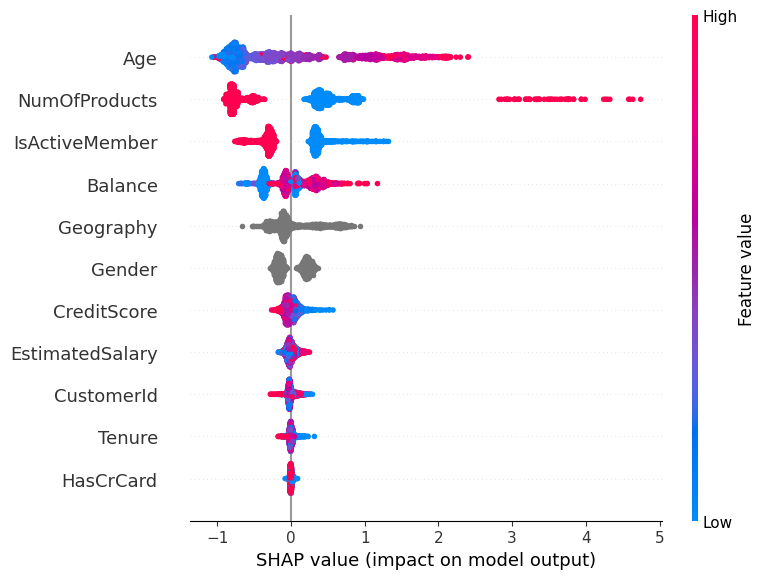

In [122]:
# summarize the effects of all the features
# в нашем случае - чем больше SHAP value - тем больше SCORE нашего целевого признака - т.е. больше отток
shap.summary_plot(shap_values, test[X])

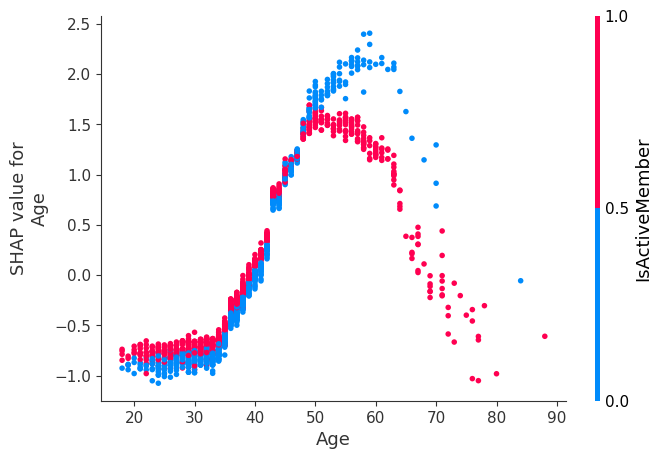

In [123]:
# смотрим на каждую фичу в отдельности:

# можно вручную перебирать каждую фичу
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age", shap_values, test[X])

In [130]:
# смотрим на каждую фичу в отдельности:

# можно вывести все графики в цикле:

features = model_2.get_feature_importance(prettified = True)['Feature Id'].values
features

array(['NumOfProducts', 'Age', 'Balance', 'Geography', 'IsActiveMember',
       'CreditScore', 'EstimatedSalary', 'Gender', 'CustomerId', 'Tenure',
       'HasCrCard'], dtype=object)

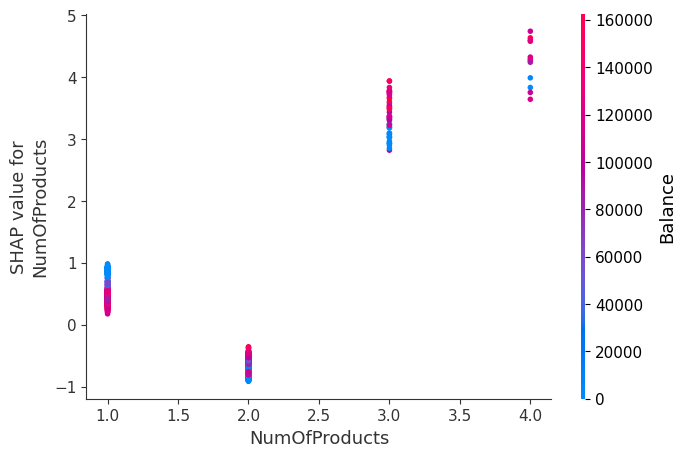

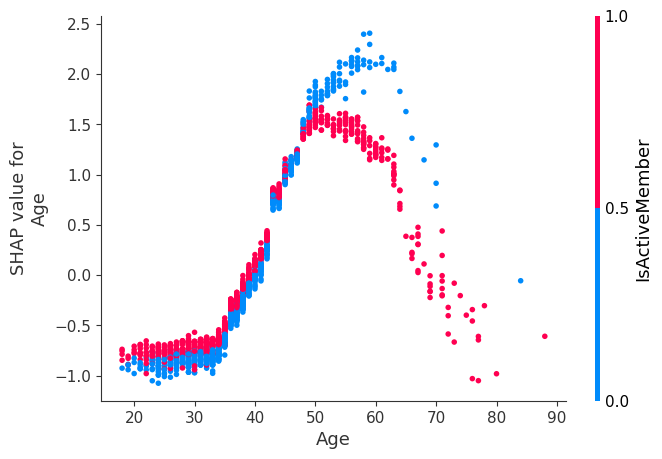

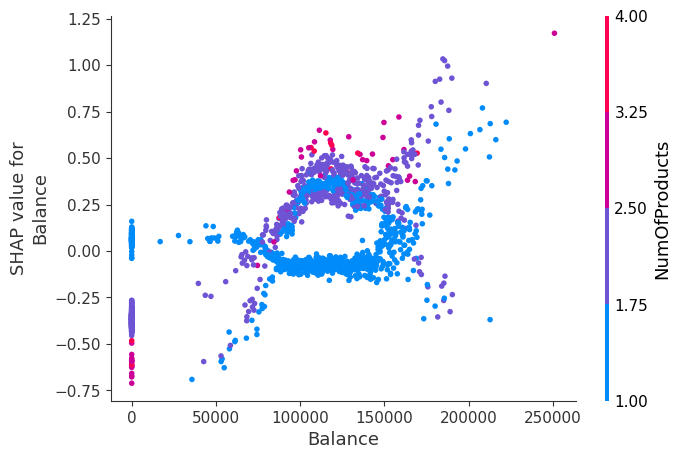

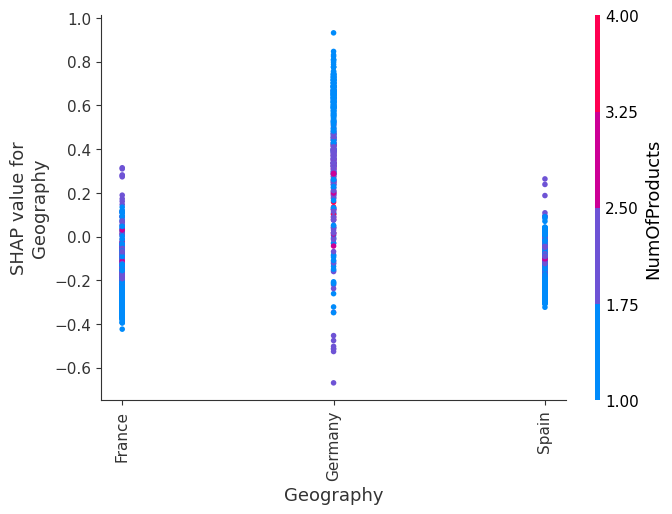

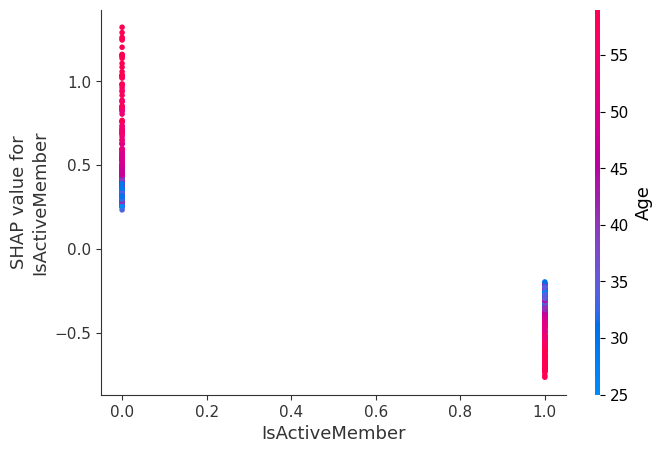

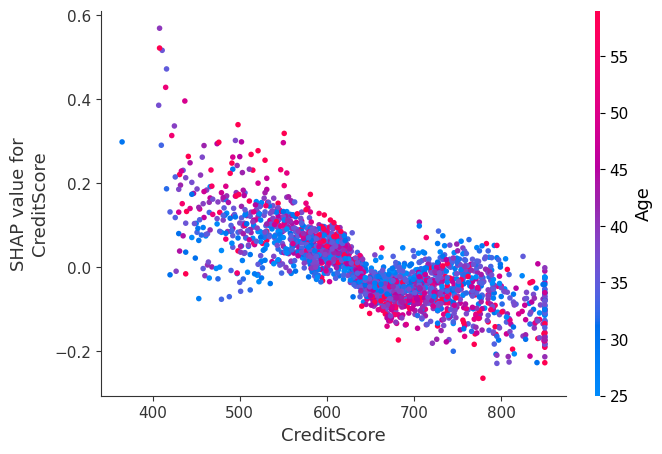

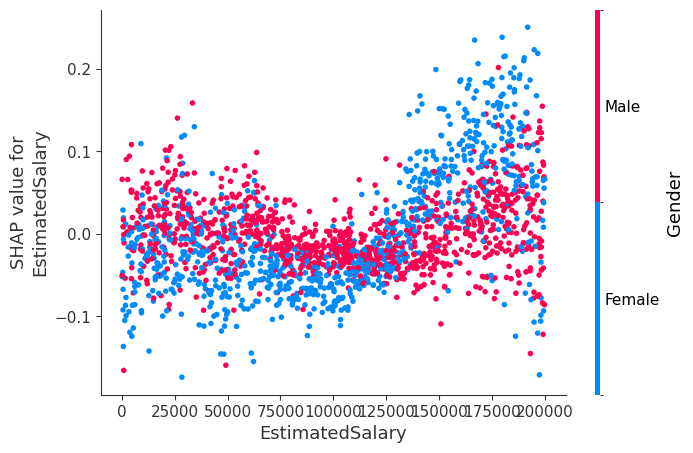

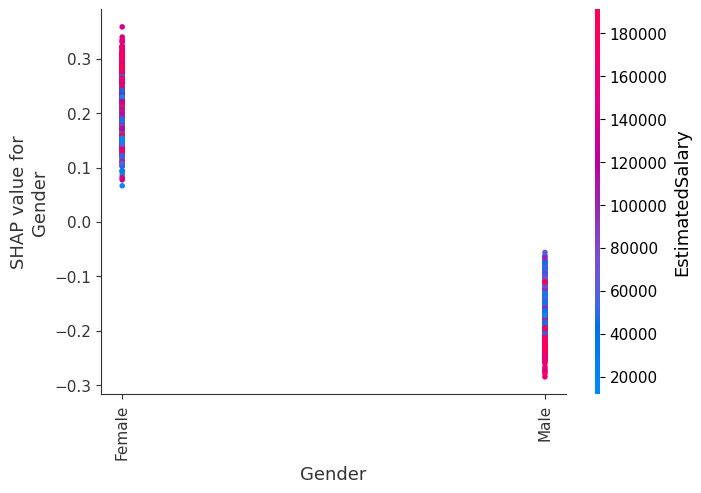

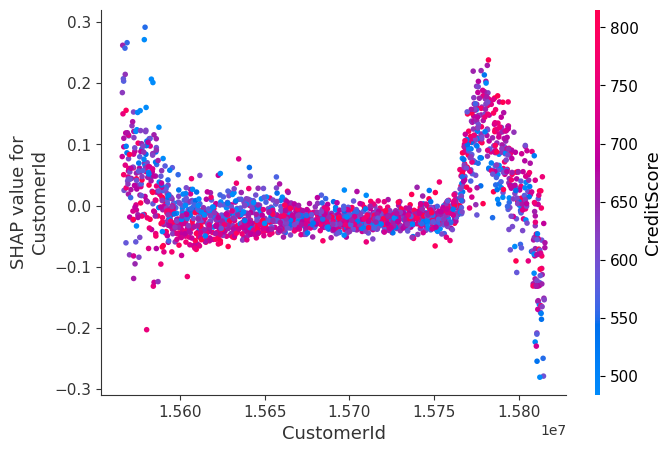

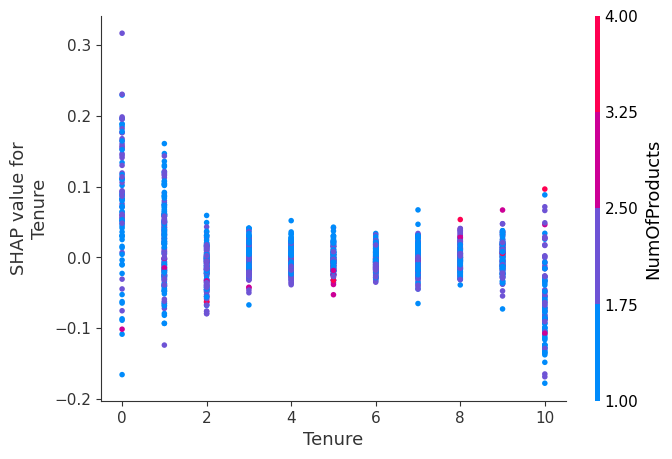

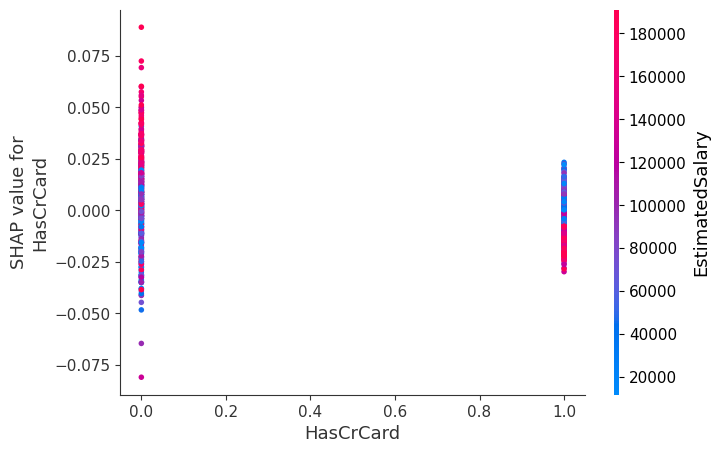

In [131]:
for feature in features:
    shap.dependence_plot(feature, shap_values, test[X])